In [4]:
import numpy as np
import pandas as pd

import datetime as dt
import time

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
from scipy.stats import gamma

import geopandas as gp
from geopandas import sjoin
import shapely as shp
from shapely.geometry import Point
import fiona as fio
from fiona.crs import from_epsg

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
ndata = pd.read_csv("data/nyc_subway_stations_with_lines.csv")

geometry = [Point(xy) for xy in zip(ndata['stop_lon'], ndata['stop_lat'])]
crs = {'init': 'epsg:4326', 'no_defs': True}
#    crs = {'init': 'epsg:2263', 'no_defs': True}
ndata_g = gp.GeoDataFrame(ndata, crs=crs, geometry=geometry)       
ndata_g = ndata_g.to_crs(epsg=2263)
ndata_g.drop(['stop_lon','stop_lat','Unnamed: 0'],axis=1,inplace=True)
ndata_g["stop_lon"] = ndata_g.centroid.map(lambda p: p.x)
ndata_g["stop_lat"] = ndata_g.centroid.map(lambda p: p.y)
ndata_g.crs

{'init': 'epsg:2263', 'no_defs': True}

In [6]:
od = pd.read_csv('nyc_journey_type.csv')
od.dropna(inplace='True')
od_trim = od[['Borough','Borough.1','Census Tract','Census Tract.1','Subway or Elevated']]
od_trim['Borough'] = od_trim['Borough'].str[1:-1]
od_trim['Borough.1'] = od_trim['Borough.1'].str[1:-1]
od_trim.rename(columns={'Borough':'Boro_home','Borough.1':'Boro_work',
                        'Census Tract':'Tract_short_home','Census Tract.1':'Tract_short_work',
                        'Subway or Elevated':'Passengers'},inplace=True)
od_trim['Pair_id'] = od_trim.index

#od_trim.head(5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [7]:
od_trim.Passengers.sum()

1428480.0

In [8]:
tracts_sh = gp.read_file('nyct2010_17b/nyct2010.shp')
tracts_sh = tracts_sh.to_crs(epsg=2263)
tracts_sh['Boro_id'] = tracts_sh.BoroCT2010.str[:1]

In [9]:
temp_h = od_trim.merge(tracts_sh,
              left_on=['Boro_home','Tract_short_home'],
              right_on=['BoroName',tracts_sh.BoroCT2010.astype(str).str[1:].astype(float)])

temp_h = temp_h[['BoroCT2010','Passengers','Pair_id']].rename(columns={'BoroCT2010':'Tract_home'})

In [10]:
temp_w = od_trim.merge(tracts_sh,
              left_on=['Boro_work','Tract_short_work'],
              right_on=['BoroName',tracts_sh.BoroCT2010.astype(str).str[1:].astype(float)])

temp_w = temp_w[['BoroCT2010','Pair_id']].rename(columns={'BoroCT2010':'Tract_work'})

In [11]:
od_dem = temp_h.merge(temp_w,on='Pair_id')
od_dem = od_dem[['Tract_home','Tract_work','Passengers']]

In [12]:
sbn = pd.read_csv('data/sub_node.csv')

mnd = pd.read_csv('data/master_node.csv')
mnd.drop('Unnamed: 0',inplace=True,axis=1)
mnd.sort_values(by='master_node_id',inplace=True)

In [13]:
id_splt = pd.DataFrame(mnd.stop_id.str.split(',').tolist(),columns=['stop_id_1','stop_id_2','stop_id_3','stop_id_4'])
mnda =  mnd.merge(id_splt,left_index=True,right_index=True).drop(['stop_id'],axis=1)

In [14]:
mrg = pd.DataFrame()

for i in ['stop_id_1','stop_id_2','stop_id_3','stop_id_4']:
    stp = mnda.merge(
        ndata_g,left_on=i,right_on='stop_id')[
        ['Borough','master_node_id','stop_name_x','stop_id_1','stop_lon','stop_lat']]
    stp.columns = ['Borough','master_node_id','stop_name','stop_id','stop_lon','stop_lat']
    mrg = pd.concat([mrg,stp]).reset_index(drop=True)

In [15]:
geometry = [Point(xy) for xy in zip(mrg['stop_lon'], mrg['stop_lat'])]
crs = {'init': 'epsg:2263', 'no_defs': True}
mrg_g = gp.GeoDataFrame(mrg, crs=crs, geometry=geometry)   

mrg_g.drop(['stop_lon','stop_lat'],axis=1,inplace=True)
mrg_g.sort_values(by='master_node_id',inplace=True)

mrg_g.crs

{'init': 'epsg:2263', 'no_defs': True}

In [16]:
stations = mrg_g.dissolve(by='master_node_id', as_index=False)

stations['center'] = stations.geometry.centroid
stations = stations.drop(['geometry'],axis=1).set_geometry('center')
stations = stations.rename(columns={'center':'geometry'}).set_geometry('geometry')

crs = {'init': 'epsg:2263', 'no_defs': True}
stations = gp.GeoDataFrame(stations, crs=crs, geometry='geometry')
stations = stations.to_crs(epsg=2263)

print stations.geometry.name, stations.crs

geometry {'init': 'epsg:2263', 'no_defs': True}


In [17]:
stations['Boro_id'] = \
    stations.Borough.apply(lambda x: x == 'M')*1 \
    +stations.Borough.apply(lambda x: x == 'Bx')*2 \
    +stations.Borough.apply(lambda x: x == 'Bk')*3 \
    +stations.Borough.apply(lambda x: x == 'Q')*4 \
    +stations.Borough.apply(lambda x: x == 'SI')*5


stations.groupby(['Borough','Boro_id']).count()

,,master_node_id,stop_name,stop_id,geometry
Borough,Boro_id,,,,
Bk,3,159,159,159,159
Bx,2,68,68,68,68
M,1,137,137,137,137
Q,4,80,80,80,80
SI,5,21,21,21,21


In [18]:
def get_shortest_walk(stat, geo, bor):
    shortest_distance = pd.DataFrame() # = []
    geo_bor = geo[geo['Boro_id'].astype(str) == bor]
    station_bor = stat[stat['Boro_id'].astype(str) == bor]
    
    tct_to_st_dist = geo_bor.geometry.centroid.apply(lambda s: station_bor.distance(s))
    tct_to_st_dist.columns = np.array(station_bor.master_node_id)
    tct_to_st_dist.index = np.array(geo_bor.BoroCT2010)
    

    return tct_to_st_dist

In [19]:
walk = pd.DataFrame()

for i in range(1,6):
    walking = pd.DataFrame(get_shortest_walk(stations,tracts_sh,str(i)).stack()).reset_index()
    walking = walking.sort_values(by=['level_0',0]).reset_index().groupby('level_0')
    walking = walking.apply(lambda df: df.iloc[0:3]).reset_index(drop=True).drop(['index'],axis=1)
    walking.columns = ['BoroCT2010','master_node_id','walking_feet']
    walk = pd.concat([walk,walking],ignore_index=True)

walk['walking_minutes'] = (walk['walking_feet']/5280)*20

In [20]:
# bring in the durations

trip_dur =  pd.read_csv('data/whole_network_duration_shortest_path.csv')

In [21]:
trip_dur['route_minutes'] = trip_dur['duration']/60
trip_dur = trip_dur[['from_master','to_master','route_minutes']].dropna()

In [22]:
trip_temp_1 = trip_dur.merge(walk,left_on='from_master',right_on='master_node_id')

trip_temp_2 = trip_temp_1[['BoroCT2010','master_node_id','from_master','walking_minutes','to_master', 'route_minutes']]
trip_temp_2.columns = ['from_tract','master_node_id','from_master','walk_from','to_master', 'route_minutes']

trip_temp_3 = trip_temp_2.merge(walk,left_on='to_master',right_on='master_node_id')

trip_temp_4 = trip_temp_3[['from_tract','BoroCT2010','from_master','to_master','walk_from','walking_minutes','route_minutes']]
trip_temp_4.rename(columns={'BoroCT2010':'to_tract','walking_minutes':'walk_to'},inplace=True)
trip_temp_4['total_walk_minutes'] = trip_temp_4['walk_from']+trip_temp_4['walk_to']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
df = trip_temp_4.merge(od_dem,left_on=['from_tract','to_tract'],right_on=['Tract_home','Tract_work'],how='inner')

df = df[df['Passengers'] > 0.00]
df.reset_index(drop=True, inplace=True)
df.drop(['Tract_home','Tract_work','walk_from','walk_to'],axis=1,inplace=True)
df.head(5)

,from_tract,to_tract,from_master,to_master,route_minutes,total_walk_minutes,Passengers
0,4048200,3003500,169 St_0,Atlantic Av - Barclays Ctr_0,56.897059,29.964065,30.0
1,4048200,3003500,Jamaica - 179 St_0,Atlantic Av - Barclays Ctr_0,58.727273,19.292774,30.0
2,4048200,3003500,Parsons Blvd_0,Atlantic Av - Barclays Ctr_0,54.936567,40.839969,30.0
3,4048200,3003500,169 St_0,Fulton St_2,52.647059,30.250636,30.0
4,4048200,3003500,Jamaica - 179 St_0,Fulton St_2,54.477273,19.579345,30.0


In [24]:
trn = pd.read_csv('data/mta_turnstile__07_23.csv')

turnstile_temp = mrg.merge(trn,left_on='stop_id',right_on='N_stop_id',how='inner')[['master_node_id','ENTRIES','EXITS']]
turnstile = turnstile_temp.groupby(['master_node_id']).sum().reset_index()
turnstile.rename(columns={'ENTRIES':'Entries','EXITS':'Exits'},inplace=True)

turnstile_work = turnstile[['master_node_id','Exits']]
turnstile_home = turnstile[['master_node_id','Entries']]

In [25]:
walk = df['total_walk_minutes']
route = df['route_minutes']


In [26]:
def mod(walk_param,route_param,data):
    tuned_walk = []
    tuned_route = []
    
    #print data
    data['expon'] = np.exp(-walk_param*walk-route_param*route)

    dfs = data.assign(expon_norm=df.expon.div(data.groupby(
        ['from_tract','to_tract']).expon.transform('sum'))).sort_values(by=['from_tract','to_tract']).reset_index()
    dfs['demand_dist'] = dfs['expon_norm']*data['Passengers']
    
    demand_work_station = dfs[['to_master','demand_dist']].groupby('to_master').sum().reset_index()
    demand_home_station = dfs[['from_master','demand_dist']].groupby('from_master').sum().reset_index()

    distribution_work = demand_work_station.merge(
        turnstile_work, left_on = 'to_master', right_on = 'master_node_id').drop(['master_node_id'],axis=1)

    distribution_home = demand_home_station.merge(
        turnstile_home, left_on = 'from_master', right_on = 'master_node_id').drop(['master_node_id'],axis=1) 
    
    
    return distribution_work.sort_values(by='to_master'),distribution_home.sort_values(by='from_master')



In [27]:
def mod2(walk_param,route_param,data):
    tuned_walk = []
    tuned_route = []
    
    #print data
    data['expon'] = np.exp(-walk_param*walk-route_param*route)

    dfs = data.assign(expon_norm=df.expon.div(data.groupby(
        ['from_tract','to_tract']).expon.transform('sum'))).sort_values(by=['from_tract','to_tract']).reset_index()
    dfs['demand_dist'] = dfs['expon_norm']*data['Passengers']
    
    #demand_work_station = dfs[['to_master','demand_dist']].groupby('to_master').sum().reset_index()
    #demand_home_station = dfs[['from_master','demand_dist']].groupby('from_master').sum().reset_index()

    #distribution = demand_work_station.merge(
    #    turnstile_work, left_on = 'to_master', right_on = 'master_node_id').drop(['master_node_id'],axis=1)

    #distribution = demand_home_station.merge(
    #    turnstile_home, left_on = 'from_master', right_on = 'master_node_id').drop(['master_node_id'],axis=1) 
    
    
    return dfs
#distribution_work.sort_values(by='to_master'),distribution_home.sort_values(by='from_master')



In [28]:
dema = mod2(.147694,.379959,df)

In [29]:
demor = dema[['from_master','to_master','demand_dist']].groupby(['from_master','to_master']).sum().reset_index()

In [30]:
demor_pivot = demor.pivot(values='demand_dist',index='from_master',columns='to_master').fillna(0)

In [31]:
demor.to_csv('data/od_demand_distribution_v2.csv')

In [32]:
demor_pivot.to_csv('data/od_demand_distribution_matrix_v2.csv')

In [33]:
tune = []
for i in np.linspace(.001,.6,50):
    #print i, dt.datetime.now()
    for j in np.linspace(.001,.6,50):
        #nw = dt.datetime.now()
        dist_work, dist_home = mod(i,j,df)
        wrk_rss = sum((dist_work['demand_dist']/sum(dist_work['demand_dist']) - dist_work['Exits']/sum(dist_work['Exits']))**2)
        hm_rss = sum((dist_home['demand_dist']/sum(dist_home['demand_dist']) - dist_home['Entries']/sum(dist_home['Entries']))**2)
        rss = wrk_rss+hm_rss
        tune.append([i,j,wrk_rss,hm_rss,rss])
        
        #print dt.datetime.now()-nw
        
results = pd.DataFrame(tune)
min_wk_rss = results[results[2] == results[2].min()]
min_hm_rss = results[results[3] == results[3].min()]
min_rss = results[results[4] == results[4].min()]

In [40]:
min_wk_rss, min_hm_rss, min_rss

rresults = pd.DataFrame(tune)
okk = results[results[4] == results[4].min()]
okk

,0,1,2,3,4
683,0.159918,0.404408,0.003684,0.00332,0.007004


In [41]:
rresults[(rresults[0] >= .1476938) & (rresults[1] >= .379)].head(3)

,0,1,2,3,4
631,0.147694,0.379959,0.003693,0.003312,0.007005
632,0.147694,0.392184,0.003688,0.003315,0.007004
633,0.147694,0.404408,0.003685,0.003320,0.007005


In [49]:
d_w, d_h = mod(.147694,.379959,df)
#d_w, d_h = mod(.13,.3,df)

d_w['dem_norm'] = d_w['demand_dist']/sum(d_w['demand_dist'])
d_h['dem_norm'] = d_h['demand_dist']/sum(d_h['demand_dist'])
d_w['Exits_Norm'] = d_w['Exits']/sum(d_w['Exits'])
d_h['Entries_Norm'] = d_h['Entries']/sum(d_h['Entries'])



In [50]:
#sum((d_h['dem_norm'] - d_h['Entries_Norm'])**2)

In [51]:
fff = sum(((dist_work['demand_dist']/sum(dist_work['demand_dist']))**2 - (dist_work['Exits']/sum(dist_work['Exits']))**2))
ggg = sum(((dist_home['demand_dist']/sum(dist_work['demand_dist']))**2 - (dist_home['Entries']/sum(dist_home['Entries']))**2))
#ggg = sum((dist_home['demand_dist']/sum(dist_home['demand_dist']) - dist_home['Entries']/sum(dist_home['Entries']))**2)
aaa = sum((d_w['demand_dist']/sum(d_w['demand_dist']) - dist_work['Exits']/sum(dist_work['Exits']))**2)
bbb = sum((dist_home['demand_dist']/sum(dist_home['demand_dist']) - dist_home['Entries']/sum(dist_home['Entries']))**2)
ss = wrk_rss+hm_rss


In [52]:
#sum(d_w['dem_norm']**2)+sum(d_w['Exits_Norm']**2)
#fff+ggg

In [53]:
demand_from_home = d_h[['from_master','demand_dist']].rename(columns={'demand_dist':'demand_from'})
demand_to_work = d_w[['to_master','demand_dist']].rename(columns={'demand_dist':'demand_to'})

In [54]:
demand_from_home = demand_from_home.sort_values(by='demand_from',ascending=False) 
#.demand_from.sum()
demand_to_work = demand_to_work.sort_values(by='demand_to',ascending=False) #.demand_to.sum()


In [55]:
demand_from_home.to_csv('data/demand_from_home_v2.csv')
demand_to_work.to_csv('data/demand_to_work_v2.csv')


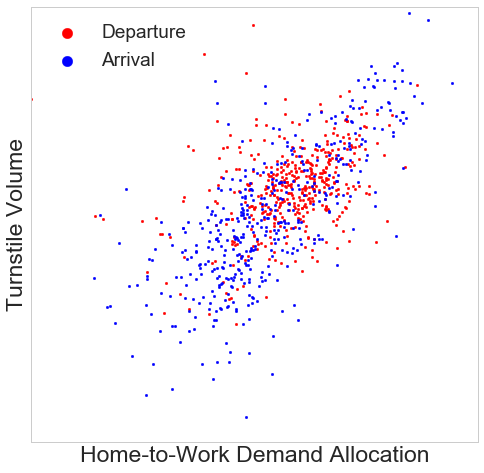

In [56]:
sns.set(style="whitegrid")


f, ax = plt.subplots(figsize=(8,8))

f.patch.set_facecolor('white')

ax.set_yticklabels([])
ax.set_xticklabels([])

plt.scatter(np.log(d_h['dem_norm']), np.log(d_h['Entries_Norm']),color='red',alpha= 1, s=7,marker='o', label="Departure")
plt.scatter(np.log(d_w['dem_norm']), np.log(d_w['Exits_Norm']), color='blue',alpha=1, s=7,marker='o',label="Arrival")

#lineStart = np.log(d_w['dem_norm']+d_h['Entries_Norm']).min() 
lineEnd = np.log(d_w['dem_norm']+d_h['Entries_Norm']).max()  
lineStart = np.log(d_h['dem_norm']).min() 
#lineEnd = np.log(d_w['Exits_Norm']).max()  


#plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'black',linewidth=1)
#plt.plot([lineStart1, lineEnd1], [lineStart1, lineEnd1], 'k-', color = 'blue',linewidth=1)


plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)

plt.xticks([])
plt.yticks([])

plt.grid([])
plt.legend(fontsize=19,markerscale=4)
#plt.title('Fit to Entry / Exit Turnstile Data',fontsize=25)

plt.xlabel("Home-to-Work Demand Allocation", fontsize=23)
plt.ylabel("Turnstile Volume", fontsize=23)

#    plt.show()



In [57]:
stats.pearsonr(d_w['dem_norm'], d_w['Exits_Norm'])

(0.70817157831763111, 2.3201503180948587e-68)

In [58]:
stats.pearsonr(d_h['dem_norm'], d_h['Entries_Norm'])

(0.23842073050153711, 4.0655670596259277e-07)

In [60]:
stats.pearsonr(np.log(d_w['dem_norm']), np.log(d_w['Exits_Norm']))


(0.72784728483225314, 6.1852489775991343e-74)

In [61]:
stats.pearsonr(np.log(d_h['dem_norm']), np.log(d_h['Entries_Norm']))

(0.37631414959384035, 2.7711043041168028e-16)

In [62]:
def cosin_sim(v, w):
    return np.dot(v, w) / np.math.sqrt(np.dot(v, v) * np.dot(w, w))

cosin_sim(d_w['dem_norm'], d_w['Exits_Norm'])

0.78568036392047369

In [63]:
cosin_sim(d_h['dem_norm'], d_h['Entries_Norm'])

0.63084503045047235

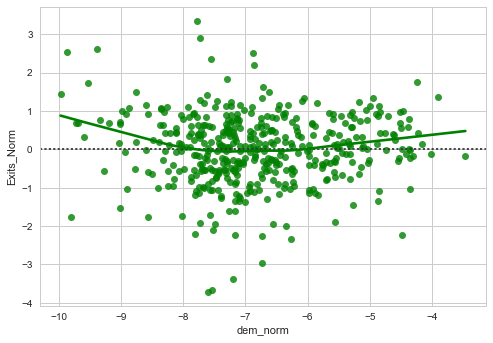

In [64]:
sns.set(style="whitegrid")

sns.residplot(np.log(d_w['dem_norm']), np.log(d_w['Exits_Norm']), lowess=True, color="g")


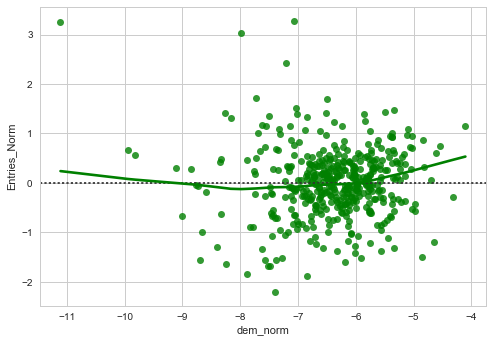

In [65]:
sns.set(style="whitegrid")
sns.residplot(np.log(d_h['dem_norm']), np.log(d_h['Entries_Norm']), lowess=True, color="g")


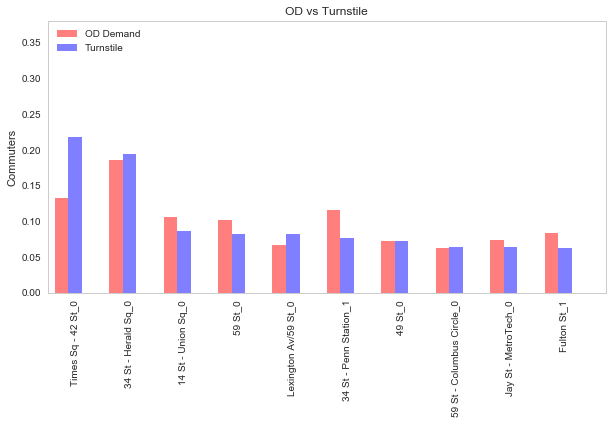

In [66]:
sort_value = 'Exits_Norm'
odd = 'dem_norm'
turnd = 'Exits_Norm'

station = 'to_master'

upper = 0
lower = 10


Sorting_OT = d_w.sort_values(by=sort_value,ascending=False).iloc[upper:lower]

Sorting_OT['demand_norm'] = Sorting_OT[odd]/Sorting_OT[odd].sum()
Sorting_OT['turn_norm'] = Sorting_OT[turnd]/Sorting_OT[turnd].sum()
#Sorting_OT['Entries_Norm'] = Sorting_OT['Entries']/Sorting_OT['Entries'].sum()
#Sorting_OT['Exits_Norm'] = Sorting_OT['Exits']/Sorting_OT['Exits'].sum()


width = 0.25
objects = Sorting_OT[station]
pos = np.arange(len(objects))



vals_od = Sorting_OT['demand_norm']
vals_t = Sorting_OT['turn_norm']


fig, ax = plt.subplots(figsize=(10,5))

plt.bar(pos,vals_od,width,alpha=0.5,color='red',label='OD Demand')

plt.bar([p + width for p in pos],vals_t,width,alpha=0.5,color='blue',label='Turnstile')


ax.set_ylabel('Commuters')

ax.set_title('OD vs Turnstile')

ax.set_xticks([p + 1 * width for p in pos])

ax.set_xticklabels(objects,rotation='vertical')

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(vals_od + vals_t)] )

plt.legend(['OD Demand', 'Turnstile'], loc='upper left')
plt.grid()
plt.show()